# Neural Networks

## 0. Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [3]:
# Path
PATH = "/content/drive/MyDrive/McGill/ECSE415/Assignment4"


# Libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import sklearn
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch import flatten
from torch.utils.data import random_split

import ultralytics
from ultralytics import YOLO

print("numpy: {}".format(np.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("cv2: {}".format(cv2.__version__))
print("sklearn: {}".format(sklearn.__version__))
print("torch: {}".format(torch.__version__))
print("torchvision: {}".format(torchvision.__version__))

numpy: 1.25.2
matplotlib: 3.7.1
cv2: 4.8.0
sklearn: 1.2.2
torch: 2.2.1+cu121
torchvision: 0.17.1+cu121


In [4]:
ultralytics.checks()

Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.9/78.2 GB disk)


## 1. CIFAR-10 Classification using Convolution Neural Network

### Classes and Functions

#### Checking Runtime Type

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # check if using CPU or CUDA
print(f"Currently running on '{device}'")

Currently running on 'cuda'


#### Defining Shallow CNN Class

In [6]:
class ConvNeuralNet(nn.Module):
  def __init__(self, num_channels, kernel_size):
    # num_channels is 1 for gray scale image input ad 3 for RGB

    super(ConvNeuralNet, self).__init__() # inherit all methods and properties from nn.Module
    self.conv_1 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=kernel_size)

    self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size)
    self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2) # should stride be 2????

    self.conv_3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel_size)

    self.conv_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel_size)

    size = 19 - 3*kernel_size # size of output after 4th layer
    self.fc_1 = nn.Linear(in_features=64 * size * size, out_features=10)

  def forward(self, x):
    x = F.relu(self.conv_1(x))
    x = F.relu(self.conv_2(x))
    x = self.pool_1(x)
    x = F.relu(self.conv_3(x))
    x = F.relu(self.conv_4(x))
    x = x.reshape(x.size(0), -1)
    x = self.fc_1(x)
    return x

# REFERENCE: https://blog.paperspace.com/writing-cnns-from-scratch-in-pytorch/

#### Train and Validation Function

In [7]:
def train_and_validate(model, device, criterion, optimizer, num_epochs, model_file):
  train_loss_list = list()
  validation_loss_list = list()
  validation_accuracy_list = list()

  max_accuracy_epoch = 0
  max_accuracy = 0

  for epoch in range(num_epochs):
    # train phase
    for i, (tra_images, tra_labels) in enumerate(trainloader):
      tra_images = tra_images.to(device)
      tra_labels = tra_labels.to(device)
      tra_outputs = model(tra_images)
      tra_loss = criterion(tra_outputs, tra_labels)

      optimizer.zero_grad() # set all gradients to zero
      tra_loss.backward() # calculate new gradients
      optimizer.step() # update the weights

    train_loss_list.append(tra_loss.item())

    # validattion phase
    model.eval() # set to evaluation mode

    #running_val_loss = 0
    val_correct_num = 0
    val_sample_num = 0
    for i, (val_images, val_labels) in enumerate(validationloader):
      val_images = val_images.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_images)
      val_loss = criterion(val_outputs, val_labels)

      # calculate validation accuracy
      val_elements, val_indices = torch.max(val_outputs, dim=1)
      val_correct_num += (val_indices == val_labels).sum().item()
      val_sample_num += val_labels.size(0)

    validation_loss_list.append(val_loss.item())
    val_accuracy = 100 * val_correct_num / val_sample_num
    validation_accuracy_list.append(val_accuracy)

    val_correct_num = 0
    val_sample_num = 0

    if epoch == 0:
      torch.save(model.state_dict(), PATH+"/models/"+model_file)
      max_accuracy = val_accuracy
    else:
      if validation_accuracy_list[epoch] > validation_accuracy_list[max_accuracy_epoch]:
        max_accuracy_epoch = epoch
        max_accuracy = val_accuracy
        torch.save(model.state_dict(), PATH+"/models/"+model_file)

    model.train() # set to training mode before next iteration

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss_list[epoch]:.4f}")
    print(f"Validation Loss: {validation_loss_list[epoch]:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    print("\n")

  print(f"Maximum validation accuracy is {max_accuracy:.2f}%")
  print(f"Saved model in ./models/{model_file} at epoch={max_accuracy_epoch+1}")
  return train_loss_list, validation_loss_list, validation_accuracy_list

# REFERENCE: https://www.baeldung.com/cs/training-validation-loss-deep-learning

#### Load Model and Test Function

In [8]:
def load_model_and_test(model, device, filename):
  model.load_state_dict(torch.load(PATH+"/models/"+filename))

  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in testloader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print(f"Test Accuracy: {(100 * correct / total):.2f}%")
  return

### Shallow CNN with kernel size 3

#### Load Dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 32
num_workers = 2


trainset = torchvision.datasets.CIFAR10(root=f"{PATH}/data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_and_validation = torchvision.datasets.CIFAR10(root=f"{PATH}/data", train=False, download=True, transform=transform)
testset, validationset = random_split(test_and_validation, [5000, 5000], generator=torch.Generator().manual_seed(42))

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


#### Creating Model

In [ ]:
model = ConvNeuralNet(num_channels=3, kernel_size=3)
if device == torch.device("cuda"):
  model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)
num_epochs = 50

#### Training and Validation

In [ ]:
start_t = time.time()
train_loss_list, validation_loss_list, validation_accuracy_list = train_and_validate(model, device, criterion, optimizer, num_epochs, "cnn_k3.pth")
print(f"\nRuntime: {(time.time() - start_t):.3f}sec")

Epoch 1/50
Train Loss: 2.2432
Validation Loss: 2.1813
Validation Accuracy: 23.80%


Epoch 2/50
Train Loss: 1.8038
Validation Loss: 1.5155
Validation Accuracy: 29.62%


Epoch 3/50
Train Loss: 1.4986
Validation Loss: 1.5964
Validation Accuracy: 35.14%


Epoch 4/50
Train Loss: 1.6490
Validation Loss: 1.3221
Validation Accuracy: 39.80%


Epoch 5/50
Train Loss: 1.6920
Validation Loss: 1.6318
Validation Accuracy: 37.08%


Epoch 6/50
Train Loss: 1.4595
Validation Loss: 1.4101
Validation Accuracy: 45.72%


Epoch 7/50
Train Loss: 1.2375
Validation Loss: 1.1560
Validation Accuracy: 46.88%


Epoch 8/50
Train Loss: 1.3325
Validation Loss: 1.1813
Validation Accuracy: 50.36%


Epoch 9/50
Train Loss: 1.6002
Validation Loss: 1.2778
Validation Accuracy: 49.52%


Epoch 10/50
Train Loss: 1.4145
Validation Loss: 1.2176
Validation Accuracy: 51.12%


Epoch 11/50
Train Loss: 1.6228
Validation Loss: 1.2405
Validation Accuracy: 52.32%


Epoch 12/50
Train Loss: 1.2310
Validation Loss: 1.0671
Validation Accuracy

#### Plotting Performance

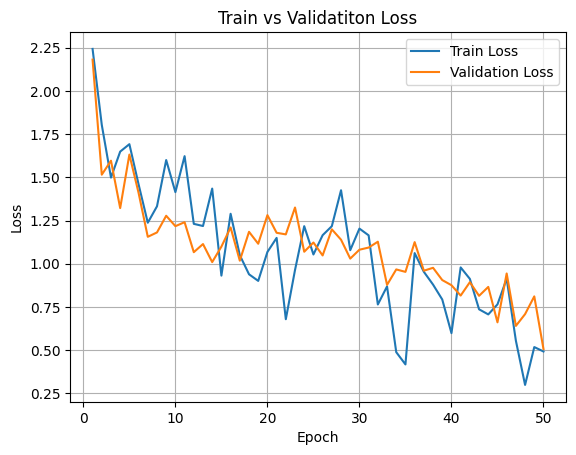

In [ ]:
xaxis = [i for i in range(1, num_epochs+1)]
plt.plot(xaxis, train_loss_list, label="Train Loss")
plt.plot(xaxis, validation_loss_list, label="Validation Loss")
plt.title("Train vs Validatiton Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

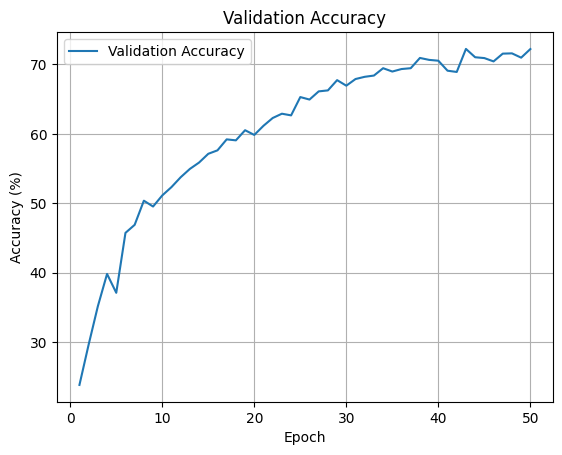

In [ ]:
plt.plot(xaxis, validation_accuracy_list, label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

#### Testing

In [ ]:
load_model_and_test(model, device, "cnn_k3.pth")

Test Accuracy: 71.44%


**Observations on Accuracy and Overfit**

Typically when an overfit occurs, the validation loss tends to increase while the train loss decreases. In this case, both validation and train loss decrease over epochs and stay at around similar values. Therefore, it is likely that this model is not overfit. Overfit may occur when the number of epochs is increased. The validation accuracy was at maximum at epoch 43 and the test accuracy of the model trained with 43 epochs was 71.44%

### Shallow CNN with kernel size 5

#### Load Dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 32
num_workers = 2


trainset = torchvision.datasets.CIFAR10(root=f"{PATH}/data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_and_validation = torchvision.datasets.CIFAR10(root=f"{PATH}/data", train=False, download=True, transform=transform)
testset, validationset = random_split(test_and_validation, [5000, 5000], generator=torch.Generator().manual_seed(42))

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


#### Creating Model

In [ ]:
model = ConvNeuralNet(num_channels=3, kernel_size=5)
if device == torch.device("cuda"):
  model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)
num_epochs = 50

#### Train and Validation

In [ ]:
start_t = time.time()
train_loss_list, validation_loss_list, validation_accuracy_list = train_and_validate(model, device, criterion, optimizer, num_epochs, "cnn_k5.pth")
print(f"\nRuntime: {(time.time() - start_t):.3f}sec")

Epoch 1/50
Train Loss: 1.9915
Validation Loss: 1.9036
Validation Accuracy: 19.46%


Epoch 2/50
Train Loss: 1.8619
Validation Loss: 1.6494
Validation Accuracy: 31.80%


Epoch 3/50
Train Loss: 1.7495
Validation Loss: 1.4762
Validation Accuracy: 36.48%


Epoch 4/50
Train Loss: 1.7371
Validation Loss: 1.4498
Validation Accuracy: 38.40%


Epoch 5/50
Train Loss: 1.3358
Validation Loss: 1.4270
Validation Accuracy: 41.20%


Epoch 6/50
Train Loss: 1.1203
Validation Loss: 1.3087
Validation Accuracy: 44.66%


Epoch 7/50
Train Loss: 1.2726
Validation Loss: 1.2574
Validation Accuracy: 45.56%


Epoch 8/50
Train Loss: 1.3136
Validation Loss: 1.3294
Validation Accuracy: 49.50%


Epoch 9/50
Train Loss: 1.8248
Validation Loss: 1.3426
Validation Accuracy: 45.86%


Epoch 10/50
Train Loss: 1.1555
Validation Loss: 1.2333
Validation Accuracy: 53.24%


Epoch 11/50
Train Loss: 1.6070
Validation Loss: 0.9529
Validation Accuracy: 51.68%


Epoch 12/50
Train Loss: 1.2497
Validation Loss: 1.1302
Validation Accuracy

#### Plotting Performance

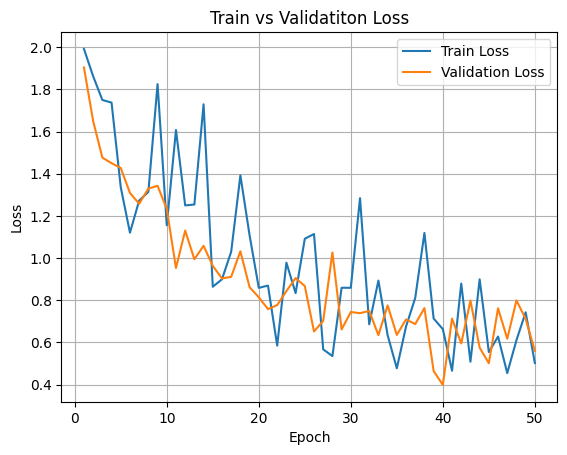

In [ ]:
xaxis = [i for i in range(1, num_epochs+1)]
plt.plot(xaxis, train_loss_list, label="Train Loss")
plt.plot(xaxis, validation_loss_list, label="Validation Loss")
plt.title("Train vs Validatiton Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

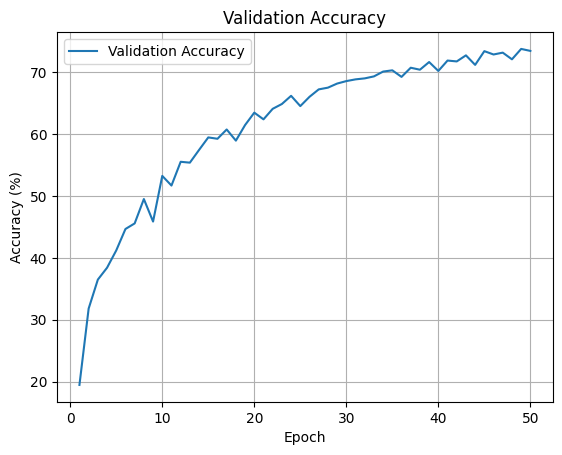

In [ ]:
plt.plot(xaxis, validation_accuracy_list, label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

#### Testing

In [ ]:
load_model_and_test(model, device, "cnn_k5.pth")

Test Accuracy: 73.36%


### Shallow CNN with kernel size 6

#### Load Dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 32
num_workers = 2


trainset = torchvision.datasets.CIFAR10(root=f"{PATH}/data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_and_validation = torchvision.datasets.CIFAR10(root=f"{PATH}/data", train=False, download=True, transform=transform)
testset, validationset = random_split(test_and_validation, [5000, 5000], generator=torch.Generator().manual_seed(42))

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


#### Creating Model

In [ ]:
model = ConvNeuralNet(num_channels=3, kernel_size=6)
if device == torch.device("cuda"):
  model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)
num_epochs = 50

#### Train and Validation

In [ ]:
start_t = time.time()
train_loss_list, validation_loss_list, validation_accuracy_list = train_and_validate(model, device, criterion, optimizer, num_epochs, "cnn_k6.pth")
print(f"\nRuntime: {(time.time() - start_t):.3f}sec")

Epoch 1/50
Train Loss: 2.2283
Validation Loss: 2.2062
Validation Accuracy: 17.38%


Epoch 2/50
Train Loss: 2.0374
Validation Loss: 1.6262
Validation Accuracy: 29.26%


Epoch 3/50
Train Loss: 1.9654
Validation Loss: 1.7262
Validation Accuracy: 33.74%


Epoch 4/50
Train Loss: 1.7881
Validation Loss: 1.4289
Validation Accuracy: 37.68%


Epoch 5/50
Train Loss: 1.7587
Validation Loss: 1.4086
Validation Accuracy: 39.04%


Epoch 6/50
Train Loss: 1.5640
Validation Loss: 1.3275
Validation Accuracy: 42.78%


Epoch 7/50
Train Loss: 1.2609
Validation Loss: 1.2687
Validation Accuracy: 44.46%


Epoch 8/50
Train Loss: 1.4911
Validation Loss: 1.2796
Validation Accuracy: 46.40%


Epoch 9/50
Train Loss: 1.1704
Validation Loss: 1.0707
Validation Accuracy: 47.84%


Epoch 10/50
Train Loss: 1.7832
Validation Loss: 1.1536
Validation Accuracy: 49.96%


Epoch 11/50
Train Loss: 1.3433
Validation Loss: 1.2969
Validation Accuracy: 50.88%


Epoch 12/50
Train Loss: 1.3052
Validation Loss: 1.0437
Validation Accuracy

#### Plotting Performance

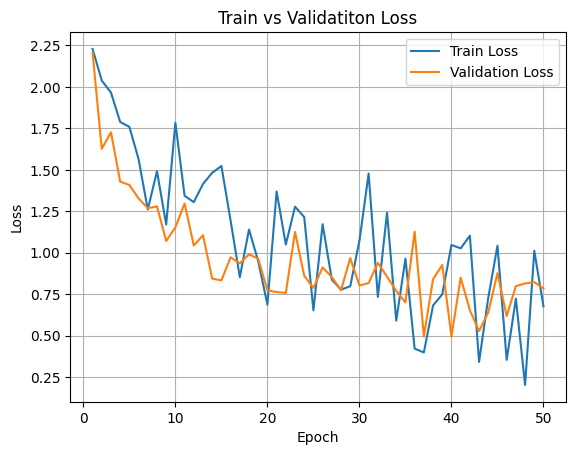

In [ ]:
xaxis = [i for i in range(1, num_epochs+1)]
plt.plot(xaxis, train_loss_list, label="Train Loss")
plt.plot(xaxis, validation_loss_list, label="Validation Loss")
plt.title("Train vs Validatiton Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

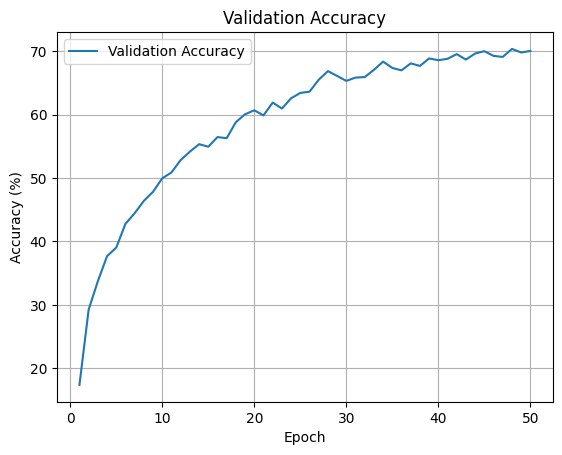

In [ ]:
plt.plot(xaxis, validation_accuracy_list, label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

In [ ]:
load_model_and_test(model, device, "cnn_k6.pth")

Test Accuracy: 69.20%


### Discussions on Shallow CNN Performance

| Kernel Size | Epochs | Test Accuracy (%) | Time (s) to train 50 epochs |
| --- | --- | --- | --- |
| 3x3 | 43 | 71.44 | 953.428 |
| 5x5 | 49 | 73.36 | 975.836 |
| 6x6 | 48 | 69.20 | 989.939 |

As the kernel size increases the execution time increases. However, in this experiment the increase in time was only around 1-2% when the kernel size increased by 1. Therefore, it is not a significant difference. The best performance was when the kernel size was 3x3. When the kernel size is small, the model tends to capture more detailed information whereas when its size is large, the model captures the information more roughly. Therefore, either extreme might end up in low performance; when too small, overfit and when too large, underfit.

### Pre-trained ResNet18

#### Load Dataset

In [ ]:
transform = transforms.Compose([transforms.Resize(size=(224, 224)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 32
num_workers = 2


trainset = torchvision.datasets.CIFAR10(root=f"{PATH}/data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_and_validation = torchvision.datasets.CIFAR10(root=f"{PATH}/data", train=False, download=True, transform=transform)
testset, validationset = random_split(test_and_validation, [5000, 5000], generator=torch.Generator().manual_seed(42))

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

100%|██████████| 170498071/170498071 [00:05<00:00, 33926535.08it/s]


Extracting /content/drive/MyDrive/ECSE415/Assignment 4/data/cifar-10-python.tar.gz to /content/drive/MyDrive/ECSE415/Assignment 4/data
Files already downloaded and verified


#### Creating Model

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=10, bias=True) # change the output to size 10
for param in model.parameters():
  param.requires_grad = True

if device == torch.device("cuda"):
  model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)
num_epochs = 10

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


#### Train and Validation

In [ ]:
start_t = time.time()
train_loss_list, validation_loss_list, validation_accuracy_list = train_and_validate(model, device, criterion, optimizer, num_epochs, "resnet18_pre_trained.pth")
print(f"\nRuntime: {(time.time() - start_t):.3f}sec")

Epoch 1/10
Train Loss: 0.3586
Validation Loss: 0.3466
Validation Accuracy: 89.96%


Epoch 2/10
Train Loss: 0.2175
Validation Loss: 0.3973
Validation Accuracy: 92.28%


Epoch 3/10
Train Loss: 0.1115
Validation Loss: 0.3305
Validation Accuracy: 93.48%


Epoch 4/10
Train Loss: 0.2448
Validation Loss: 0.5034
Validation Accuracy: 93.92%


Epoch 5/10
Train Loss: 0.1545
Validation Loss: 0.4962
Validation Accuracy: 94.06%


Epoch 6/10
Train Loss: 0.2573
Validation Loss: 0.3916
Validation Accuracy: 94.12%


Epoch 7/10
Train Loss: 0.1992
Validation Loss: 0.3529
Validation Accuracy: 94.46%


Epoch 8/10
Train Loss: 0.0171
Validation Loss: 0.3019
Validation Accuracy: 94.56%


Epoch 9/10
Train Loss: 0.0406
Validation Loss: 0.2694
Validation Accuracy: 94.32%


Epoch 10/10
Train Loss: 0.4574
Validation Loss: 0.3307
Validation Accuracy: 94.54%


Maximum validation accuracy is 94.56%
Saved model in ./models/resnet18_pre_trained.pth at epoch=8

Runtime: 1640.151sec


#### Plotting Performance

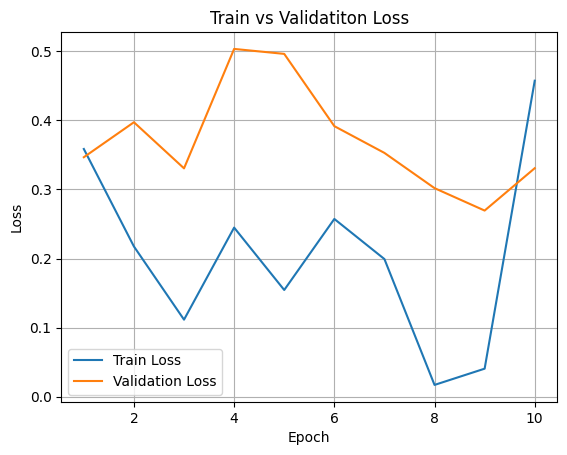

In [ ]:
xaxis = [i for i in range(1, num_epochs+1)]
plt.plot(xaxis, train_loss_list, label="Train Loss")
plt.plot(xaxis, validation_loss_list, label="Validation Loss")
plt.title("Train vs Validatiton Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

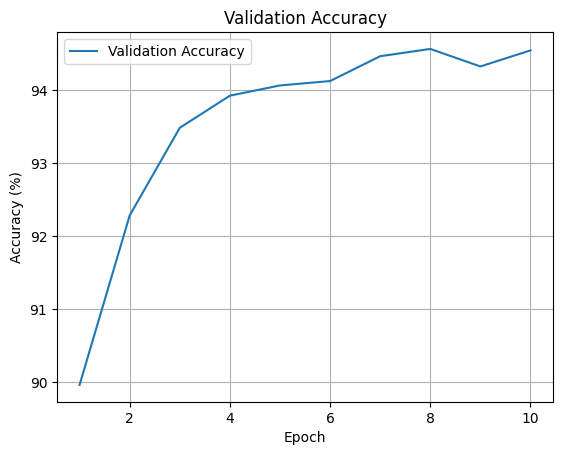

In [ ]:
plt.plot(xaxis, validation_accuracy_list, label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

#### Testing

In [ ]:
load_model_and_test(model, device, "resnet18_pre_trained.pth")

Test Accuracy: 93.28%


### Non-pre-trained ResNet18

#### Load Dataset

In [ ]:
transform = transforms.Compose([transforms.Resize(size=(224, 224)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 32
num_workers = 2


trainset = torchvision.datasets.CIFAR10(root=f"{PATH}/data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_and_validation = torchvision.datasets.CIFAR10(root=f"{PATH}/data", train=False, download=True, transform=transform)
testset, validationset = random_split(test_and_validation, [5000, 5000], generator=torch.Generator().manual_seed(42))

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


#### Creating Model

In [ ]:
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(in_features=512, out_features=10, bias=True) # change the output to size 10
for param in model.parameters():
  param.requires_grad = True

if device == torch.device("cuda"):
  model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)
num_epochs = 10

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


#### Train and Validation

In [ ]:
start_t = time.time()
train_loss_list, validation_loss_list, validation_accuracy_list = train_and_validate(model, device, criterion, optimizer, num_epochs, "resnet18_non_pre_trained.pth")
print(f"\nRuntime: {(time.time() - start_t):.3f}sec")

Epoch 1/10
Train Loss: 1.5444
Validation Loss: 1.9367
Validation Accuracy: 36.30%


Epoch 2/10
Train Loss: 1.1083
Validation Loss: 1.1028
Validation Accuracy: 47.32%


Epoch 3/10
Train Loss: 0.9654
Validation Loss: 1.0303
Validation Accuracy: 51.52%


Epoch 4/10
Train Loss: 1.2437
Validation Loss: 1.1271
Validation Accuracy: 55.62%


Epoch 5/10
Train Loss: 0.8418
Validation Loss: 1.1922
Validation Accuracy: 57.86%


Epoch 6/10
Train Loss: 0.9970
Validation Loss: 1.5428
Validation Accuracy: 57.80%


Epoch 7/10
Train Loss: 0.8260
Validation Loss: 0.9789
Validation Accuracy: 63.54%


Epoch 8/10
Train Loss: 1.0008
Validation Loss: 0.9796
Validation Accuracy: 64.26%


Epoch 9/10
Train Loss: 0.5607
Validation Loss: 0.8649
Validation Accuracy: 66.12%


Epoch 10/10
Train Loss: 0.8088
Validation Loss: 0.7938
Validation Accuracy: 67.22%


Maximum validation accuracy is 67.22%
Saved model in ./models/resnet18_non_pre_trained.pth at epoch=10

Runtime: 1640.906sec


#### Plotting Performance

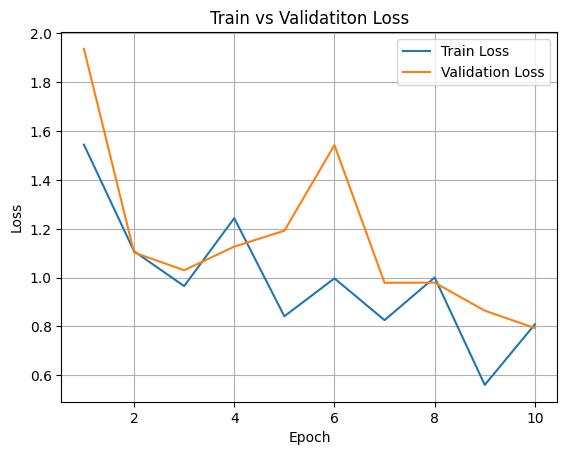

In [ ]:
xaxis = [i for i in range(1, num_epochs+1)]
plt.plot(xaxis, train_loss_list, label="Train Loss")
plt.plot(xaxis, validation_loss_list, label="Validation Loss")
plt.title("Train vs Validatiton Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

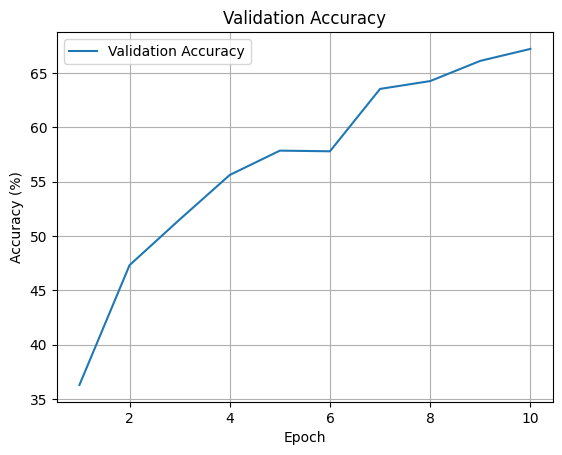

In [ ]:
plt.plot(xaxis, validation_accuracy_list, label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

#### Testing

In [ ]:
load_model_and_test(model, device, "resnet18_non_pre_trained.pth")

Test Accuracy: 67.12%


### Discussions on Pre-trained or Non-pre-trained ResNet18 Performance

| Type | Epochs | Test Accuracy (%) | Time (s) to train 10 epochs |
| --- | --- | --- | --- |
| Pre-trained | 8 | 93.28 | 1640.151 |
| Non-pre-trained | 10 | 67.12 | 1640.906 |

The pre-trained validation accuracy began from 92.28% (epoch 1) and augumented to 94.56% at maximum during the training phase. In the learning curve, the validation loss seemed to be constantly higher than the training loss. However, the scale of the y-axis is one-third of the non-pre-trained one. Therefore, the model is likely not facing overfit.

The non-pre-trained validation accuracy began from 36.30% (epoch 1) and increased to 67.22% in 10 epochs. Due to computational resources, there were difficulties increasing the number of epochs. However, further training was necessary to gain insight to the non-pre-trained model.

### Discussions on ResNet18 and Shallow CNN

The pre-trained ResNet18 was already at a higher validation accuracy in the beginning of training as the best validation accuracy of the shallow CNN trained over 50 epochs. When comparing the non-pre-trained ResNet18 to the shallow CNN, in the first 10 epochs, the validation accuracy of the former increased from 19.46% to 53.24%, and the latter increased from 36.30% to 67.22%. For the model to reach 60% validation accuracy, the former took around 17 epochs while the latter took only 6 epochs. The approximated time to train 1 epoch was 20 sec and 164 sec respectively. Therefore, from the data acquired, the shallow CNN learns more effectively in terms of time and the increase in accuracy. However, more epochs of training is necessary to determine where the validation accuracy converges to know the final test accuracy of the best model because just by prediction, the shallow CNN validation accuracy seems to be starting to converge after 50 epochs at around 75% accuracy whereas the ResNet18 validation accuracy seems to be still growing at the end of training.

## 2. YOLOv8 Object Detection on Montréal Streets

### Loading Image

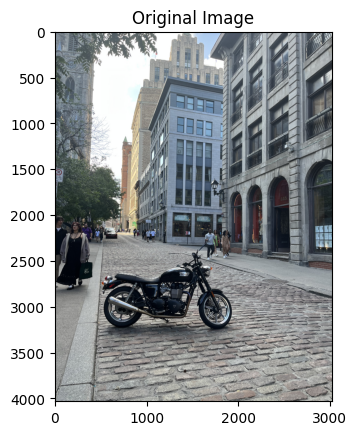

In [15]:
img_1 = cv2.imread(PATH + "/data/motorbike.jpg")
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
plt.title("Original Image")
plt.imshow(img_1)

### Creating Model

In [16]:
model = YOLO("yolov8n.pt")
model.train(data='coco128.yaml', epochs=3)
model.val()

# REFERENCE: https://github.com/ultralytics/ultralytics?tab=readme-ov-file
# REFERENCE: https://colab.research.google.com/github/ultralytics/ultralytics/blob/main/examples/tutorial.ipynb

100%|██████████| 6.23M/6.23M [00:00<00:00, 85.1MB/s]


Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco128.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

100%|██████████| 6.66M/6.66M [00:00<00:00, 81.9MB/s]
Unzipping /content/datasets/coco128.zip to /content/datasets/coco128...: 100%|██████████| 263/263 [00:00<00:00, 3664.67file/s]

Dataset download success ✅ (0.9s), saved to /content/datasets



100%|██████████| 755k/755k [00:00<00:00, 17.4MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /content/datasets/coco128/labels/train2017... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 1928.89it/s]

train: New cache created: /content/datasets/coco128/labels/train2017.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      2.74G      1.152      1.595      1.249        228        640: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        128        929      0.682      0.515      0.612      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      2.64G      1.142      1.376      1.218        151        640: 100%|██████████| 8/8 [00:02<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        128        929      0.699      0.519      0.622      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      2.59G       1.15      1.313      1.226        164        640: 100%|██████████| 8/8 [00:02<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


                   all        128        929      0.689      0.525      0.627      0.468

3 epochs completed in 0.008 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


                   all        128        929      0.689      0.525      0.628      0.469
                person        128        254      0.822       0.65      0.767       0.54
               bicycle        128          6      0.626      0.333      0.333      0.275
                   car        128         46      0.903      0.217       0.28      0.174
            motorcycle        128          5       0.73        0.8      0.898      0.718
              airplane        128          6      0.754      0.833      0.913      0.716
                   bus        128          7      0.737      0.714      0.737      0.676
                 train        128          3       0.56      0.667      0.806      0.726
                 truck        128         12          1      0.367      0.522      0.328
                  boat        128          6      0.292      0.167       0.35      0.254
         traffic light        128         14       0.73      0.197      0.201      0.138
             stop sig

val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


                   all        128        929      0.698      0.532      0.626      0.466
                person        128        254      0.829      0.646      0.768      0.542
               bicycle        128          6      0.614      0.333       0.33      0.274
                   car        128         46      0.901      0.217      0.279      0.175
            motorcycle        128          5      0.729        0.8      0.898      0.718
              airplane        128          6      0.753      0.833      0.913      0.716
                   bus        128          7       0.78      0.714      0.738      0.662
                 train        128          3      0.559      0.667      0.806      0.726
                 truck        128         12          1      0.394      0.538       0.34
                  boat        128          6      0.247      0.167      0.355      0.167
         traffic light        128         14      0.717      0.186      0.201      0.138
             stop sig

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 79])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ca4c75cc340>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,

### Predicting and Displaying Image


image 1/1 /content/drive/MyDrive/ECSE415/Assignment 4/data/motorbike.jpg: 640x480 7 persons, 1 car, 1 motorcycle, 1 suitcase, 13.7ms
Speed: 3.4ms preprocess, 13.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


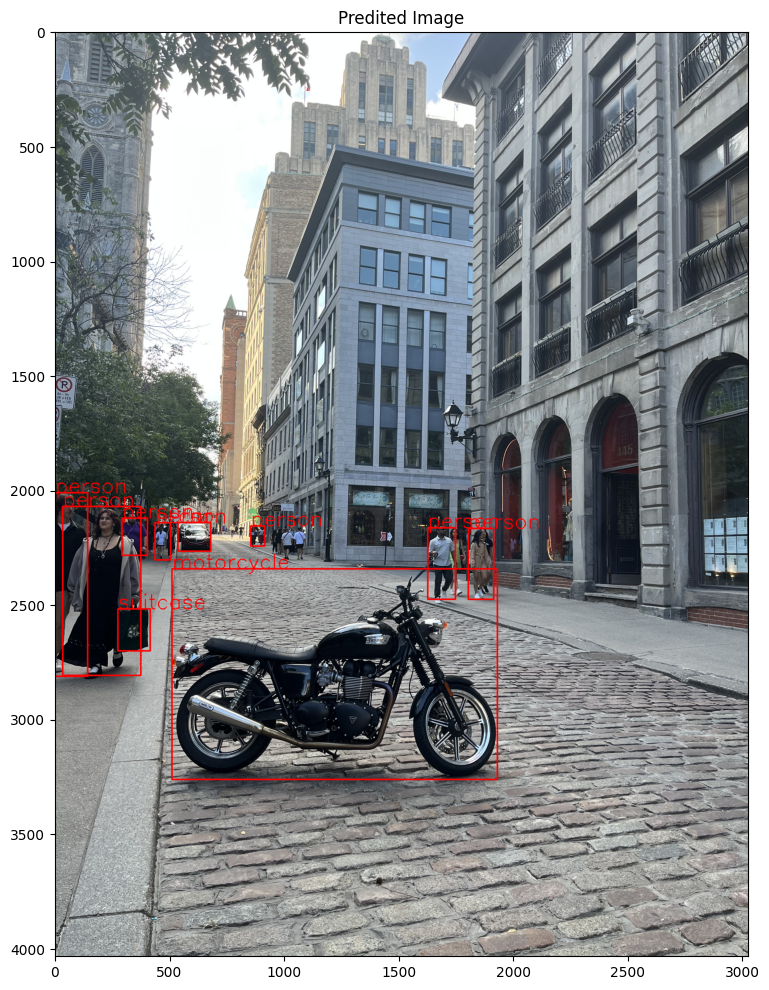

In [17]:
results = model(PATH + "/data/motorbike.jpg")
result = results[0]
boxes = result.boxes.cpu().numpy()
xyxys = boxes.xyxy # bounding box coordinates
class_ids = boxes.cls # predicted classes

predicted_img = img_1.copy()
detected_objects = dict()

for i, xyxy in enumerate(xyxys):
  cv2.rectangle(predicted_img, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (255, 0, 0), 5) # draw bounding box
  class_name = result.names[class_ids[i]]
  cv2.putText(predicted_img, class_name, (int(xyxy[0]), int(xyxy[1])), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 3, 1) # write class name near the bounding box
  if class_name in detected_objects.keys():
    detected_objects[class_name] += 1
  else:
    detected_objects[class_name] = 1

plt.figure(figsize = (12,12))
plt.title("Predited Image")
plt.imshow(predicted_img)

### Counting Objects

In [18]:
print("\n#-----Detected Objects-----#")
for cls in detected_objects:
  print(f"{cls}: {detected_objects[cls]}")
print("#-------------------------------#")


#-----Detected Objects-----#
motorcycle: 1
person: 7
car: 1
suitcase: 1
#-------------------------------#
